## Model 3: Convolutional Neural Network 

In [1]:
import os, glob
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import sklearn
import keras

Using TensorFlow backend.


In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, BatchNormalization, Dropout
from keras.models import model_from_yaml
from keras import initializers
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import plot_model

### Step 1: importing data and dividing into train and test 

In [3]:
features_likes = pd.read_csv('features_likes_subset.csv')

In [4]:
X= features_likes.iloc[:,1:4097]
Y= features_likes.iloc[:, 4097:]

In [85]:
from sklearn.model_selection import train_test_split 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=222, shuffle=True)

We reshape the X matrix to adapt it to CNN structure

In [86]:
X_train_new = np.array(X_train)

In [87]:
X_train_new.shape = ([-1, 8,8,64])

In [88]:
X_train_new.shape

(33120, 8, 8, 64)

In [89]:
X_test_new = np.array(X_test)

In [90]:
X_test_new.shape = ([-1, 8,8,64])

### Step 2: Creating the model

#### Version A: CNN with no regularization

In [91]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [92]:
def create_model(metrics = METRICS, 
                 filters_1=32, filters_2 = 64, filters_3 = 128,
                 units_1 = 100, units_2 = 80, units_3 = 50,
                 output_bias= -4, #correcting for unbalanced data log(average#positives/total#obs)
                 learning = 1e-3):
    
    model = Sequential()
    model.add(Conv2D(filters= filters_1,#dimensionality of the output space (number of output filters in the convolution)
                      kernel_size=(3,3), #height and width of the 2D convolution window
                      input_shape = (8,8,64),#8X8 with 64 channels
                      data_format= 'channels_last',
                      activation = 'relu'))
    model.add(Conv2D(filters= filters_2,
                      kernel_size=(3,3), 
                      activation = 'relu'))
    model.add(Conv2D(filters= filters_3,
                      kernel_size=(3,3),
                      activation = 'relu'))
    model.add(Flatten())
    model.add(Dense(units = units_1, activation='relu'))
    model.add(Dense(units = units_2, activation='relu'))
    model.add(Dense(units = units_3, activation='relu'))
    model.add(Dense(Y_train.shape[1], activation='sigmoid', 
                    bias_initializer= initializers.Constant(output_bias)))
    
    model.compile(
      optimizer=keras.optimizers.Adam(lr=learning),
      loss=keras.losses.BinaryCrossentropy(),
      metrics= METRICS)
    
    return model

In [93]:
model = create_model()

In [94]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 6, 6, 32)          18464     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 4, 4, 64)          18496     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 2, 2, 128)         73856     
_________________________________________________________________
flatten_8 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 100)               51300     
_________________________________________________________________
dense_30 (Dense)             (None, 80)                8080      
_________________________________________________________________
dense_31 (Dense)             (None, 50)               

#### Version B: CNN with regularization and barch normalization

In [12]:
def create_model_2(metrics = METRICS, 
                 output_bias= -4, #correcting for unbalanced data log(average#positives/total#obs)
                 learning = 1e-3, 
                 regularizer = 0.0005) :
    model = Sequential()
    model.add(Conv2D(filters= 32,#dimensionality of the output space (number of output filters in the convolution)
                      kernel_size=(3,3), #height and width of the 2D convolution window
                      input_shape = (8,8,64),#8X8 with 64 channels
                      data_format= 'channels_last',
                      kernel_regularizer = regularizers.l2(regularizer),
                      activation = 'relu'))
    model.add(Conv2D(filters= 64,
                      kernel_size=(3,3), 
                      activation = 'relu',
                      kernel_regularizer = regularizers.l2(regularizer)))
    model.add(Conv2D(filters= 128,
                      kernel_size=(3,3),
                      activation = 'relu', 
                      kernel_regularizer = regularizers.l2(regularizer)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(units = 100, activation='relu'))
    model.add(Dense(units = 80, activation='relu'))
    model.add(Dense(units = 50, activation='relu'))
    model.add(Dense(Y_train.shape[1], activation='sigmoid',                
                    bias_initializer= initializers.Constant(output_bias)))
    
    model.compile(
        optimizer=keras.optimizers.Adam(lr=learning),
        loss=keras.losses.BinaryCrossentropy(),
        metrics= METRICS)
    
    return model

In [13]:
mod_final = create_model_2()

In [14]:
mod_final.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 6, 6, 32)          18464     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 128)         73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 2, 128)         512       
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               51300     
_________________________________________________________________
dense_2 (Dense)              (None, 80)               

### Step 3: Fitting and saving the models

#### Version A:

In [55]:
results_val_0 = model.fit(X_train_new, Y_train, 
                      batch_size=40, epochs=10)

Epoch 1/10
33120/33120 [==============================] - 86s 3ms/step - loss: 0.0812 - tp: 5.0000 - fp: 3.0000 - tn: 4300271.0000 - fn: 71561.0000 - accuracy: 0.9836 - precision: 0.6250 - recall: 6.9866e-05 - auc: 0.6418: 3s - loss: 0.0815 - tp: 5.0000 - fp: 3.0000 - tn: 4133728.0000 - fn: 69144.0000 - accuracy: 0.9835 - precision: 0.6250 - 
Epoch 2/10
33120/33120 [==============================] - 486s 15ms/step - loss: 0.0797 - tp: 15.0000 - fp: 28.0000 - tn: 4300246.0000 - fn: 71551.0000 - accuracy: 0.9836 - precision: 0.3488 - recall: 2.0960e-04 - auc: 0.6812
Epoch 3/10
33120/33120 [==============================] - 122s 4ms/step - loss: 0.0790 - tp: 19.0000 - fp: 45.0000 - tn: 4300229.0000 - fn: 71547.0000 - accuracy: 0.9836 - precision: 0.2969 - recall: 2.6549e-04 - auc: 0.6977 12s - loss: 0.0791 - tp: 17.0000 - fp: 42.0000 - tn: 3863846.0000 - fn: 64415.0000 - accuracy: 0.9836 - precision:  - ETA: 8s - loss: 0.0789 - tp: 18.0000 - fp: 44.0000 - tn: 3988639.0000 - fn: 66339.0000

In [188]:
#run = {}
#run['tp'] = [5,15,19,32,128,908,2019,2759,3230,3569]
#run['fp'] = [3,28,45,52,160,741,1617,1911,2195,2324]
#run['loss'] = [0.0812,0.0797, 0.0790, 0.0783,0.0772,0.0753,0.0734, 0.0718,0.0708,0.0699]
#run['epoch']= [1,2,3,4,5,6,7,8,9,10]

In [189]:
#results_val_0 = pd.DataFrame(run)

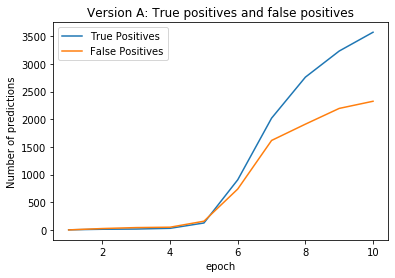

In [190]:
# summarize history for true positives and false positives
plt.plot(results_val_0['epoch'], results_val_0['tp'])
plt.plot(results_val_0['epoch'], results_val_0['fp'])
plt.title('Version A: True positives and false positives')
plt.ylabel('Number of predictions')
plt.xlabel('epoch')
plt.legend(['True Positives', 'False Positives'], loc='upper left')
plt.show()

In [111]:
model_yaml = model.to_yaml()
with open('model_CNN.yaml', 'w') as yaml_file:
    yaml_file.write(model_yaml)
model.save_weights('model_CNN.h5')
print('Saved model_CNN to disk')

Saved model_CNN to disk


In [166]:
# load model from disk
yaml_file = open('model_CNN.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
model_CNN = model_from_yaml(loaded_model_yaml)

# load weights into new model
model_CNN.load_weights("model_CNN.h5")
print("Loaded model from disk")

Loaded model from disk


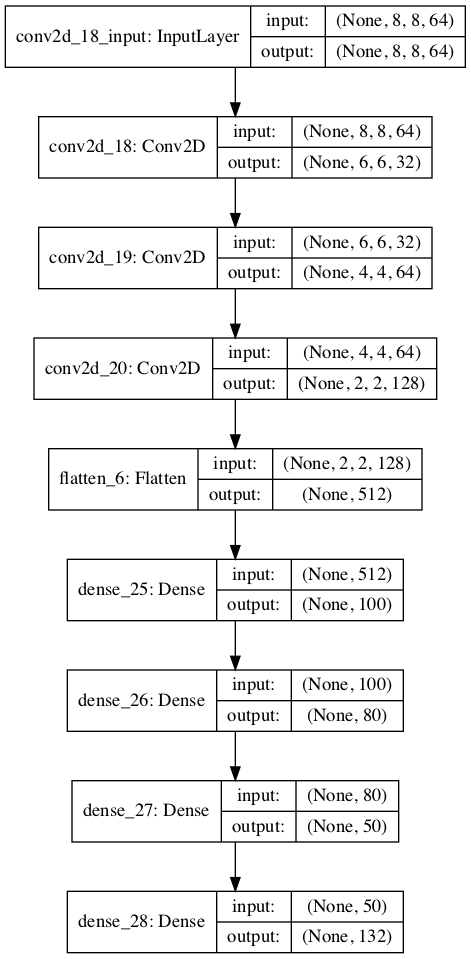

In [13]:
plot_model(model_CNN, to_file='model_CNN_plot.png', show_shapes=True, show_layer_names=True)

Including weights: 

In [95]:
weights = np.empty([132, 2])
for i in range(132):
    weights[i] = [1,60]

In [130]:
results_val_1 = model_weighted.fit(X_train_new, Y_train, 
                                 class_weight = weights,
                                 batch_size = 40, epochs = 10)

Epoch 1/10
33120/33120 [==============================] - 87s 3ms/step - loss: 0.0612 - tp: 6709.0000 - fp: 3649.0000 - tn: 4296625.0000 - fn: 64857.0000 - accuracy: 0.9843 - precision: 0.6477 - recall: 0.0937 - auc: 0.8740
Epoch 2/10
33120/33120 [==============================] - 84s 3ms/step - loss: 0.0604 - tp: 7076.0000 - fp: 3814.0000 - tn: 4296460.0000 - fn: 64490.0000 - accuracy: 0.9844 - precision: 0.6498 - recall: 0.0989 - auc: 0.8788
Epoch 3/10
33120/33120 [==============================] - 83s 3ms/step - loss: 0.0595 - tp: 7553.0000 - fp: 3948.0000 - tn: 4296326.0000 - fn: 64013.0000 - accuracy: 0.9845 - precision: 0.6567 - recall: 0.1055 - auc: 0.8852
Epoch 4/10
33120/33120 [==============================] - 86s 3ms/step - loss: 0.0586 - tp: 8125.0000 - fp: 4100.0000 - tn: 4296174.0000 - fn: 63441.0000 - accuracy: 0.9846 - precision: 0.6646 - recall: 0.1135 - auc: 0.8901: 45s - loss: 0.0575 - tp: 4224.0000 - fp: 2094.0000 - tn: 2096133.0000 - fn: 30 - ETA: 41s - loss: 0.057

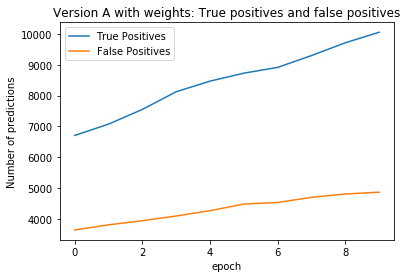

In [191]:
# summarize history for true positives and false positives
plt.plot(results_val_1.history['tp'])
plt.plot(results_val_1.history['fp'])
plt.title('Version A with weights: True positives and false positives')
plt.ylabel('Number of predictions')
plt.xlabel('epoch')
plt.legend(['True Positives', 'False Positives'], loc='upper left')
plt.show()

In [133]:
model_yalm = model_weighted.to_yaml()
with open('model_CNN_w_final.yaml', 'w') as yaml_file:
    yaml_file.write(model_yaml)
model_weighted.save_weights('model_CNN_w_final.h5')
print('Saved model_CNN_w_final to disk')

Saved model_CNN_w_final to disk


#### Version B 

In [104]:
results_val = mod_final.fit(X_train_new, Y_train, 
                            class_weight = weights,
                            epochs = 10, batch_size = 40)

Epoch 1/10
33120/33120 [==============================] - 84s 3ms/step - loss: 0.0847 - tp: 34.0000 - fp: 109.0000 - tn: 4300165.0000 - fn: 71532.0000 - accuracy: 0.9836 - precision: 0.2378 - recall: 4.7509e-04 - auc: 0.6654
Epoch 2/10
33120/33120 [==============================] - 86s 3ms/step - loss: 0.0807 - tp: 13.0000 - fp: 26.0000 - tn: 4300248.0000 - fn: 71553.0000 - accuracy: 0.9836 - precision: 0.3333 - recall: 1.8165e-04 - auc: 0.6833
Epoch 3/10
33120/33120 [==============================] - 87s 3ms/step - loss: 0.0803 - tp: 15.0000 - fp: 24.0000 - tn: 4300250.0000 - fn: 71551.0000 - accuracy: 0.9836 - precision: 0.3846 - recall: 2.0960e-04 - auc: 0.6887
Epoch 4/10
33120/33120 [==============================] - 88s 3ms/step - loss: 0.0801 - tp: 10.0000 - fp: 23.0000 - tn: 4300251.0000 - fn: 71556.0000 - accuracy: 0.9836 - precision: 0.3030 - recall: 1.3973e-04 - auc: 0.6922
Epoch 5/10
33120/33120 [==============================] - 89s 3ms/step - loss: 0.0798 - tp: 15.0000 - f

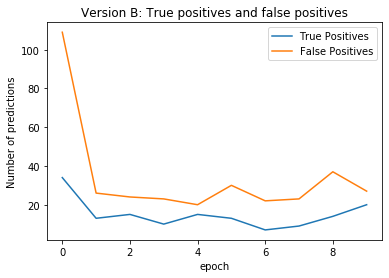

In [173]:
# summarize history for true positives and false positives
plt.plot(results_val.history['tp'])
plt.plot(results_val.history['fp'])
plt.title('Version B: True positives and false positives')
plt.ylabel('Number of predictions')
plt.xlabel('epoch')
plt.legend(['True Positives', 'False Positives'], loc='upper right')
plt.show()

#### Comparing models

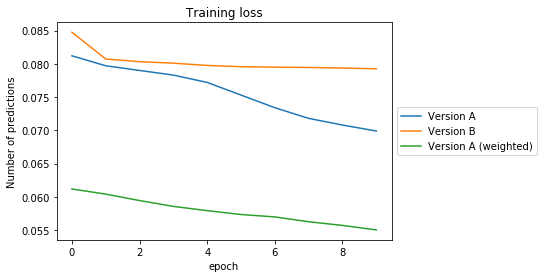

In [193]:
# summarize history for true positives and false positives
plt.plot(results_val_0['loss'])
plt.plot(results_val.history['loss'])
plt.plot(results_val_1.history['loss'])
plt.title('Training loss')
plt.ylabel('Number of predictions')
plt.xlabel('epoch')
plt.legend(['Version A','Version B', 'Version A (weighted)'], loc = 'center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [128]:
model_yaml = mod_final.to_yaml()
with open('model_CNN_reg_final.yaml', 'w') as yaml_file:
    yaml_file.write(model_yaml)
    
mod_final.save_weights('model_CNN_reg_final.h5')
print('Saved model_CNN_reg_final to disk')

Saved model_CNN_reg_final to disk


In [129]:
# load model from disk
yaml_file = open('model_CNN_reg.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
mod_final = model_from_yaml(loaded_model_yaml)

# load weights into new model
mod_final.load_weights("model_CNN_reg.h5")
print("Loaded model from disk")

Loaded model from disk


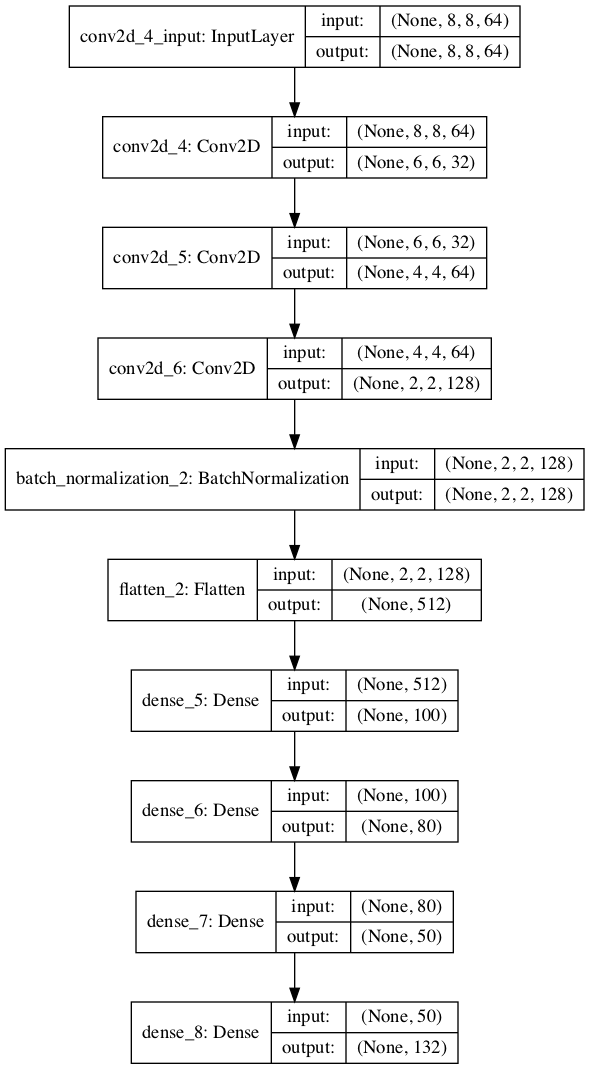

In [15]:
plot_model(mod_final, to_file='model_CNN_reg_plot.png', show_shapes=True, show_layer_names=True)

### Step 4: Evaluating the models: 

In [99]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score

In [101]:
def evaluate_thresholds(Y_prob):
    threshold=list(np.arange(0.001,0.5, 0.001))
    precision=[]
    recall = []
    for i in threshold: 
        Y_pred_thr = np.where(Y_prob > i, 1, 0)
        precision.append(precision_score(Y_test, Y_pred_thr, average = 'micro'))
        recall.append(recall_score(Y_test, Y_pred_thr, average = 'micro'))

    data_thresholds = pd.DataFrame(threshold)
    data_thresholds = data_thresholds.rename(columns = {0:'threshold'})
    data_thresholds['precision'] = precision
    data_thresholds['recall']= recall
    
    return data_thresholds

In [116]:
Y_test = Y_test.values

#### Version A (no regularization no weights) 

In [167]:
Y_prob_CNN = model_CNN.predict(X_test_new)

In [168]:
data_th = evaluate_thresholds(Y_prob_CNN)

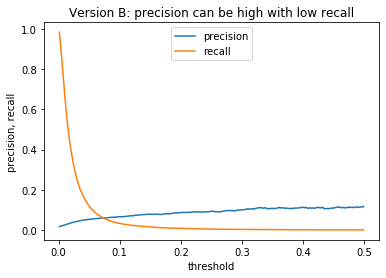

In [176]:
plt.plot(data_th['threshold'], data_th['precision'])
plt.plot(data_th['threshold'], data_th['recall'])
plt.title('Version B: precision can be high with low recall' )
plt.ylabel('precision, recall')
plt.xlabel('threshold')
plt.legend(['precision', 'recall'], loc='upper center')
plt.show()

Maximizing precision, we get: 

In [ ]:
max_prec= max(data_th['precision'])
max_prec

In [33]:
data_th.loc[data_th['precision']==max_prec]

,threshold,precision,recall
497,0.498,0.117647,0.001016


In [34]:
Y_pred_max_prec = np.where(Y_prob_CNN > 0.498, 1, 0)

In [35]:
cm = pd.DataFrame(confusion_matrix(Y_test.flatten(), Y_pred_max_prec.flatten()))
cm_perc = round(cm*(1/1873740)*100,2)

In [38]:
cm

,0,1
0,1842017,240
1,31451,32


In [40]:
cm_perc

,0,1
0,98.31,0.01
1,1.68,0.00


In [36]:
print(classification_report(Y_test.flatten(), Y_pred_max_prec.flatten()))
print('Precision:', precision_score(Y_test, Y_pred_max_prec, average = 'micro'))
print('Recall:', recall_score(Y_test, Y_pred_max_prec, average = 'micro'))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99   1842257
         1.0       0.12      0.00      0.00     31483

    accuracy                           0.98   1873740
   macro avg       0.55      0.50      0.50   1873740
weighted avg       0.97      0.98      0.97   1873740

Precision: 0.11764705882352941
Recall: 0.0010164215608423593


Setting recall at around 40%: 

In [53]:
data_th.loc[(data_th['recall']>0.4) & (data_th['recall']<0.42)]

,threshold,precision,recall
18,0.019,0.034607,0.418639


In [55]:
Y_pred_max_rec = np.where(Y_prob_CNN > 0.019, 1, 0)
cm = pd.DataFrame(confusion_matrix(Y_test.flatten(), Y_pred_max_rec.flatten()))
cm_perc = round(cm*(1/1873740)*100,2)
print(classification_report(Y_test.flatten(), Y_pred_max_rec.flatten()))
print('Precision:', precision_score(Y_test, Y_pred_max_rec, average = 'micro'))
print('Recall:', recall_score(Y_test, Y_pred_max_rec, average = 'micro'))

              precision    recall  f1-score   support

         0.0       0.99      0.80      0.88   1842257
         1.0       0.03      0.42      0.06     31483

    accuracy                           0.79   1873740
   macro avg       0.51      0.61      0.47   1873740
weighted avg       0.97      0.79      0.87   1873740

Precision: 0.03460707318161887
Recall: 0.41863863037194676


In [56]:
cm

,0,1
0,1474590,367667
1,18303,13180


In [57]:
cm_perc

,0,1
0,78.70,19.62
1,0.98,0.70


#### Version B: no regularization but weights

In [136]:
Y_prob_w = model_weighted.predict(X_test_new)

In [139]:
data_th_w = evaluate_thresholds(Y_prob_w)

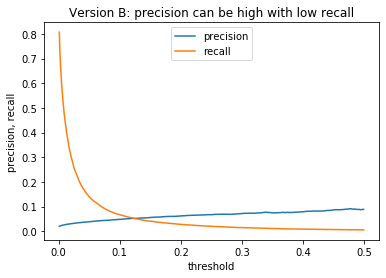

In [175]:
plt.plot(data_th_w['threshold'], data_th_w['precision'])
plt.plot(data_th_w['threshold'], data_th_w['recall'])
plt.title('Version B: precision can be high with low recall' )
plt.ylabel('precision, recall')
plt.xlabel('threshold')
plt.legend(['precision', 'recall'], loc='upper center')
plt.show()

Maximizing precision, we get: 

In [142]:
data_th_w.loc[data_th_w['precision']==max(data_th_w['precision'])]

,threshold,precision,recall
475,0.476,0.091537,0.006734


In [146]:
Y_pred_max_pred = np.where(Y_prob_w > 0.476, 1, 0)
cm = pd.DataFrame(confusion_matrix(Y_test.flatten(), Y_pred_max_pred.flatten()))
cm_perc = round(cm*(1/1873740)*100,2)
print(classification_report(Y_test.flatten(), Y_pred_max_pred.flatten()))
print('Precision:', precision_score(Y_test, Y_pred_max_pred, average = 'micro'))
print('Recall:', recall_score(Y_test, Y_pred_max_pred, average = 'micro'))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99   1842257
         1.0       0.09      0.01      0.01     31483

    accuracy                           0.98   1873740
   macro avg       0.54      0.50      0.50   1873740
weighted avg       0.97      0.98      0.97   1873740

Precision: 0.09153713298791019
Recall: 0.006733792840580631


In [147]:
cm

,0,1
0,1840153,2104
1,31271,212


In [148]:
cm_perc

,0,1
0,98.21,0.11
1,1.67,0.01


Setting recall at around 40% we get: 

In [149]:
data_th_w.loc[(data_th_w['recall']>0.4) & (data_th_w['recall']<0.5)]

,threshold,precision,recall
8,0.009,0.026277,0.476702
9,0.010,0.026833,0.455452
10,0.011,0.027391,0.436426
11,0.012,0.027863,0.417654


In [150]:
Y_pred_max_pred = np.where(Y_prob_w > 0.012, 1, 0)
cm = pd.DataFrame(confusion_matrix(Y_test.flatten(), Y_pred_max_pred.flatten()))
cm_perc = round(cm*(1/1873740)*100,2)
print(classification_report(Y_test.flatten(), Y_pred_max_pred.flatten()))
print('Precision:', precision_score(Y_test, Y_pred_max_pred, average = 'micro'))
print('Recall:', recall_score(Y_test, Y_pred_max_pred, average = 'micro'))

              precision    recall  f1-score   support

         0.0       0.99      0.75      0.85   1842257
         1.0       0.03      0.42      0.05     31483

    accuracy                           0.75   1873740
   macro avg       0.51      0.58      0.45   1873740
weighted avg       0.97      0.75      0.84   1873740

Precision: 0.027863304733307764
Recall: 0.41765397198488075


In [151]:
cm

,0,1
0,1383495,458762
1,18334,13149


In [152]:
cm_perc

,0,1
0,73.84,24.48
1,0.98,0.70


#### Version B: Including regularization, batch normalization and weights

In [108]:
Y_prob_final = mod_final.predict(X_test_new)

In [109]:
data_th_r = evaluate_thresholds(Y_prob_final)

/Users/teresamorales/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


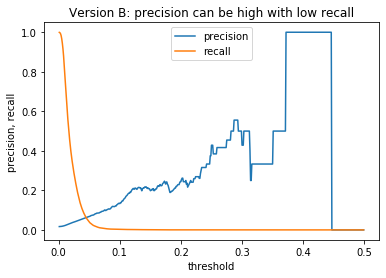

In [127]:
plt.plot(data_th_r['threshold'], data_th_r['precision'])
plt.plot(data_th_r['threshold'], data_th_r['recall'])
plt.title('Version B: precision can be high with low recall' )
plt.ylabel('precision, recall')
plt.xlabel('threshold')
plt.legend(['precision', 'recall'], loc='upper center')
plt.show()

Maximizing prediction we get: 

In [114]:
data_th_r.loc[data_th_r['precision']==max(data_th_r['precision'])]

,threshold,precision,recall
371,0.372,1.0,0.000032
372,0.373,1.0,0.000032
373,0.374,1.0,0.000032
374,0.375,1.0,0.000032
375,0.376,1.0,0.000032
...,...,...,...
441,0.442,1.0,0.000032
442,0.443,1.0,0.000032
443,0.444,1.0,0.000032
444,0.445,1.0,0.000032


In [117]:
Y_pred_max_pred = np.where(Y_prob_final > 0.372, 1, 0)
cm = pd.DataFrame(confusion_matrix(Y_test.flatten(), Y_pred_max_pred.flatten()))
cm_perc = round(cm*(1/1873740)*100,2)
print(classification_report(Y_test.flatten(), Y_pred_max_pred.flatten()))
print('Precision:', precision_score(Y_test, Y_pred_max_pred, average = 'micro'))
print('Recall:', recall_score(Y_test, Y_pred_max_pred, average = 'micro'))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99   1842257
         1.0       1.00      0.00      0.00     31483

    accuracy                           0.98   1873740
   macro avg       0.99      0.50      0.50   1873740
weighted avg       0.98      0.98      0.97   1873740

Precision: 1.0
Recall: 3.176317377632373e-05


In [118]:
cm

,0,1
0,1842257,0
1,31482,1


In [119]:
cm_perc

,0,1
0,98.32,0.0
1,1.68,0.0


Setting recall at around 40% we get: 

In [121]:
data_th_r.loc[(data_th_r['recall']>0.4) & (data_th_r['recall']<0.5)]

,threshold,precision,recall
16,0.017,0.030516,0.485437
17,0.018,0.031825,0.454055
18,0.019,0.033091,0.423848


In [124]:
Y_pred_max_rec = np.where(Y_prob_final > 0.019, 1, 0)
cm = pd.DataFrame(confusion_matrix(Y_test.flatten(), Y_pred_max_rec.flatten()))
cm_perc = round(cm*(1/1873740)*100,2)
print(classification_report(Y_test.flatten(), Y_pred_max_rec.flatten()))
print('Precision:', precision_score(Y_test, Y_pred_max_rec, average = 'micro'))
print('Recall:', recall_score(Y_test, Y_pred_max_rec, average = 'micro'))

              precision    recall  f1-score   support

         0.0       0.99      0.79      0.88   1842257
         1.0       0.03      0.42      0.06     31483

    accuracy                           0.78   1873740
   macro avg       0.51      0.61      0.47   1873740
weighted avg       0.97      0.78      0.86   1873740

Precision: 0.03309088835048964
Recall: 0.42384779087126384


In [125]:
cm

,0,1
0,1452348,389909
1,18139,13344


In [126]:
cm_perc

,0,1
0,77.51,20.81
1,0.97,0.71


### Step 5: comparing versions 

Version A with and withoug weights: 

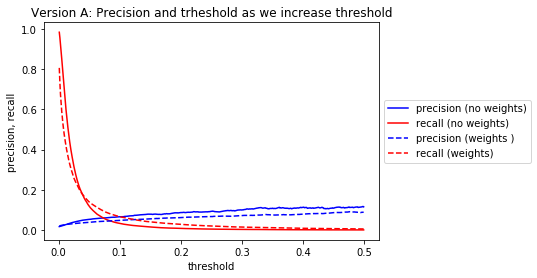

In [178]:
plt.plot(data_th['threshold'], data_th['precision'], color = 'b')
plt.plot(data_th['threshold'], data_th['recall'], 'r')
plt.plot(data_th_w['threshold'], data_th_w['precision'], 'b', linestyle='dashed')
plt.plot(data_th_w['threshold'], data_th_w['recall'], 'r', linestyle='dashed')
plt.title('Version A: Precision and trheshold as we increase threshold')
plt.ylabel('precision, recall')
plt.xlabel('threshold')
plt.legend(['precision (no weights)' , 'recall (no weights)', 'precision (weights )', 'recall (weights)'], 
           loc = 'center left', bbox_to_anchor=(1, 0.5))
plt.show()

Version A without weights and version B: 

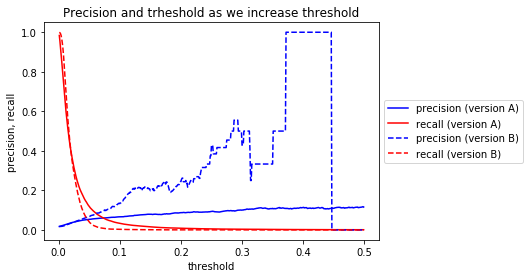

In [172]:
plt.plot(data_th['threshold'], data_th['precision'], color = 'b')
plt.plot(data_th['threshold'], data_th['recall'], 'r')
plt.plot(data_th_r['threshold'], data_th_r['precision'], 'b', linestyle='dashed')
plt.plot(data_th_r['threshold'], data_th_r['recall'], 'r', linestyle='dashed')
plt.title('Precision and trheshold as we increase threshold')
plt.ylabel('precision, recall')
plt.xlabel('threshold')
plt.legend(['precision (version A)' , 'recall (version A)', 'precision (version B)', 'recall (version B)'], 
           loc = 'center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Future work:  GridSearch 

With time, we would like to tweak hyperparameters to find the best combination

In [179]:
def save_model(model, i):
    model_yaml = model.to_yaml()
    with open('model_CNN' + i + '.yaml', 'w') as yaml_file:
        yaml_file.write(model_yaml)
    model.save_weights('model_CNN'+i+'.h5')
    print('Saved model_CNN' +i+ 'to disk')

In [194]:
param_grid = dict(epochs = [5,10,15], 
                  learning = [1e-2,1e-3,1e-4], 
                  output_bias = [-3,-4,-5],
                  regularizer = [0.0001, 0.0005, 0.001], 
                  batch_size = [40,50,60]
                 ) 

In [195]:
import itertools as it

allNames = sorted(param_grid)
combinations = it.product(*(param_grid[Name] for Name in allNames))
models = list(combinations)

In [196]:
len(models)

243

In [197]:
allNames

['batch_size', 'epochs', 'learning', 'output_bias', 'regularizer']

In [ ]:
from random import randrange

mod = {}
results_validation = {}

for j in range(60): #randomly run 60 models  
    i = randrange(len(models))
    
    mod[i] = create_model(output_bias = models[i][3], 
                          learning = models[i][2],
                          regularizer = models[i][4])
    
    results_validation[i] = mod[i].fit(X_train_new, Y_train,
                                        epochs = models[i][1],
                                        batch_size = models[i][0])
    
    print('model '+'j'+' with index ' + 'i' + ' run successfully')
    
    save_model(mod[i], i)
    
    print('model '+'j'+' with index ' + 'i' + ' saved')